In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data_collector import Omie

from ml import GaussianKernel, ComputationMode, load_kernels_dict
from potenciala import BucketMethod, FigureShape, SingleTimeSeries, VectorTimeSeries
from stochastic import (EulerMaruyama, ConstantDiffusionMultivariate, SpatialDifferenceDriftMultivariate, 
                        SpatialDiffusionUnivariate, SpatialDriftMultivariate, SpatialNearestDriftMultivariate)

In [3]:
# uncomment this to obtain most up-to-date day ahead market timeseries
#df = Omie.download_period_file(filename="marginalpdbc", start_year=2016, end_year=2021)
#df = Omie.include_old_file(df=df, filename="marginalpdbc_2002_2015.csv")

In [4]:
df_raw = pd.read_csv("day_ahead_market_20211005.csv")
df_raw["spain"] = df_raw["spain"].round(decimals=2)

In [5]:
# filter data before 2004 (missing dates in 2003) and beyond 2021
df = df_raw.query("year >= 2004 & year <= 2020")

### Univariate timeseries

In [ ]:
s_1 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Round, bin_size=1)
s_025 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)

In [ ]:
s_1.plot_ts()

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))
s_1.potential.loc[:120].plot(ax=ax0)
s_025.potential.loc[:120].plot(ax=ax1)
ax0.set_title("1 €/MW resolution")
ax1.set_title("0.25 €/MW resolution")
plt.show()

### Include all history or last n years

In [ ]:
# Compare potential across different years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compare potential across different years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compute accumulative years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compute accumulative years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Check n-year period
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Check n-year period divided by minimum
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# plot mean drift and diffusion
_ = s_1.drift.mean["drift_1"].iloc[:120].plot()

In [ ]:
_ = s_1.diffusion.mean["diffusion_1"].iloc[:120].plot()

In [ ]:
a = s_1.drift.mean["drift_1"]
a = a.reindex(np.arange(0, a.index.max() + 20)).fillna(0)
b = s_1.diffusion.mean["diffusion_1"]
b = b.reindex(np.arange(0, b.index.max() + 20)).fillna(0)

x_df = s_1.df[(s_1.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[0]

In [ ]:
drift = SpatialDriftMultivariate(df=a.to_frame())
diffusion = SpatialDiffusionUnivariate(df=b.to_frame())

em_1 = EulerMaruyama(num_sim=1000, period=24*6, delta_t=1, nu=0, drift=drift, diffusion=diffusion)

In [ ]:
sim_df = em_1.simulate(x0=np.array([x_0]), random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[:,  :em_1.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
plt.show()

### Multivariate  timeseries $D_{1}^i(x)$ 

In [ ]:
s = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.Round, bin_size=1, 
                     diff_matrix_xi_xj_computation=False)

In [ ]:
s.plot_hourly_boxplot()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.drift_hour_x.iloc[:, :100], ax=ax, cmap='flare', vmin=-50, vmax=50)
ax.set_title("Mean 24-hour drift")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.potential_hour_x.iloc[:, :100], ax=ax, cmap='flare', vmin=-400, vmax=100)
ax.set_title("Potential")
fig.show()

In [ ]:
m = 6
n = int(24/m)
fig, ax = plt.subplots(n, 1, figsize=(20, 25))
for i in range(n):
    s.potential_hour_x.loc[i*m+1:(i+1)*m].T.plot(ax=ax[i])
    ax[i].legend(loc=1)
    ax[i].set_xlim(0, 180)
    ax[i].set_ylim(-450, 150)
ax[0].set_title("Potential")
fig.show()

In [ ]:
fig, axis = plt.subplots(4, 6, figsize=(40, 25))

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*6+j
        s.potential_hour_x.loc[h].plot(ax=ax)
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=30)
        ax.set_xlim(0, 100)
        ax.set_ylim(-450, 50)
        ax.tick_params(axis='both', labelsize=20)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.text(0.5, 0.095, "spot price $X_{t}^{i}$ [€/MWh]", ha="center", va="center", fontdict={"size": 25})
fig.text(0.1, 0.5, "potential $[(€/MWh)^{2}/day]$", ha="center", va="center",
         fontdict={"size": 25}, rotation=90)

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
potential = s.potential_hour_x.iloc[:, :100].stack().reset_index()
ax.scatter(potential.iloc[:, 0], potential.iloc[:, 1], potential.iloc[:, 2])
ax.set_xlabel("hour")
ax.set_ylabel("Spot price [€/Mwh]")
ax.set_zlabel("potential")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s.diffusion_matrix, dtype=bool), k=1)
sns.heatmap(s.diffusion_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

In [ ]:
s.diffusion_matrix

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s.sqrt_diff_matrix, dtype=bool), k=1)
sns.heatmap(s.sqrt_diff_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

#### Simulation with $D_{1}^i(x)$ and diagonal $D_{2}^{ii}$

In [ ]:
x_df = s.df[(s.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[:24].values

In [ ]:
spatial_drift = SpatialDriftMultivariate(df=s.drift_hour_x)
diag_diff_matrix = pd.DataFrame(np.sqrt(np.diag(np.diag(s.diffusion_matrix))))
diag_diffusion = ConstantDiffusionMultivariate(df=diag_diff_matrix)

em_2 = EulerMaruyama(num_sim=1000, period=6, delta_t=1, nu=0, drift=spatial_drift, diffusion=diag_diffusion)

In [ ]:
sim_df = em_2.simulate(x0=x_0, random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_2.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 80)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^{i}(x)$ and diagonal $D_2^{ii}$")
plt.show()

#### Simulation with $D_{1}^i(x)$ and non-diagonal constant $D_{2}^{ij}$

In [ ]:
x_df = s.df[(s.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[:24].values

In [ ]:
spatial_drift = SpatialDriftMultivariate(df=s.drift_hour_x)
cte_diffusion = ConstantDiffusionMultivariate(df=pd.DataFrame(s.sqrt_diff_matrix))

em_3 = EulerMaruyama(num_sim=1000, period=6, delta_t=1, nu=0, drift=spatial_drift, diffusion=cte_diffusion)

In [ ]:
sim_df = em_3.simulate(x0=x_0, random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_3.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 80)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^i(x)$ and non-diagonal $D_2^{ij}$")
plt.show()

### Multivariate timeseries  - $D_{1}^{i}(X_{d}^i - X_{d-1}^i)$ 

In [ ]:
s_back_drift = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.Round, bin_size=1, x_transformation="back_drift")

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.samples_hour_x.iloc[:, :200], ax=ax, cmap='flare')#, vmin=-40, vmax=40)
ax.set_title("Samples 24-hour drift")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.drift_hour_x, ax=ax, cmap='flare')#, vmin=-40, vmax=40)
ax.set_title("Mean 24-hour drift")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.potential_hour_x, ax=ax, cmap='flare')
ax.set_title("Potential")
fig.show()

In [ ]:
m = 6
n = int(24/m)
fig, ax = plt.subplots(n, 1, figsize=(20, 25))
for i in range(n):
    s_back_drift.potential_hour_x.loc[i*m+1:(i+1)*m].T.plot(ax=ax[i])
    ax[i].legend(loc=1)
    ax[i].set_xlim(-80, 80)
    #ax[i].set_ylim(-450, 150)
ax[0].set_title("Potential")
fig.show()

In [ ]:
fig, axis = plt.subplots(4, 6, figsize=(40, 25))

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*6+j
        s_back_drift.potential_hour_x.loc[h].plot(ax=ax)
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=30)
        ax.set_xlim(-60, 60)
        ax.set_ylim(-800, 50)
        ax.tick_params(axis='both', labelsize=20)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.text(0.5, 0.095, "spot price difference $X_{t}^{i} - X_{t-1}^{i}$ [€/MWh]", ha="center", va="center", fontdict={"size": 25})
fig.text(0.1, 0.5, "potential $[(€/MWh)^{2}/day]$", ha="center", va="center",
         fontdict={"size": 25}, rotation=90)

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
potential = s_back_drift.potential_hour_x.stack().reset_index()
ax.scatter(potential.iloc[:, 0], potential.iloc[:, 1], potential.iloc[:, 2])
ax.set_xlabel("hour")
ax.set_ylabel("X")
ax.set_zlabel("potential")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s_back_drift.diffusion_matrix, dtype=bool), k=1)
sns.heatmap(s_back_drift.diffusion_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

#### Simulation with $D_{1}^i(X_{d}^i - X_{d-1}^i)$ and non-diagonal constant $D_{2}^{ij}$

In [ ]:
x_df = s_back_drift.df[(s_back_drift.df["date"] >= "2020-12-09")].iloc[:24*7]
t_0 = x_df["spain"].iloc[:24].values
t_1 = x_df["spain"].iloc[24:48].values
x_0 = np.vstack([t_0, t_1]).T

In [ ]:
spatial_diff_drift = SpatialDifferenceDriftMultivariate(df=s_back_drift.drift_hour_x)
cte_diffusion = ConstantDiffusionMultivariate(df=pd.DataFrame(s_back_drift.sqrt_diff_matrix))

em_4 = EulerMaruyama(num_sim=1000, period=7, delta_t=1, nu=0, drift=spatial_diff_drift, diffusion=cte_diffusion)

In [ ]:
sim_df = em_4.simulate(x0=x_0, random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[48:, : em_4.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).iloc[24:].plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].iloc[24:].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[48:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 80)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation for $D_1^i(X_d^i - X_{d-1}^i)$ and non-diagonal $D_2^{ij}$")
plt.show()

## Gaussian kde

In [6]:
from matplotlib.lines import Line2D

In [7]:
s_kde = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.NoBucket)

In [8]:
def compute_historical_mean(df: pd.DataFrame, x_label_col_name: str, value_col_name: str):
    
    aux_df = df.copy(deep=True)
    aux_df[x_label_col_name] = aux_df[x_label_col_name].round(decimals=0)
    mean_x = aux_df.groupby(x_label_col_name)[value_col_name].mean()
    
    return mean_x

def plot_samples_kernel_mean_expected(ax: plt.axes, 
                                      gk: GaussianKernel, 
                                      historical_mean: pd.Series, 
                                      ymax_lim: float = None):

    ax.plot(gk.samples[0], gk.samples[1], 'k.', markersize=2, alpha=0.2)
    ax.plot(gk.expected_value_function[0, :], gk.expected_value_function[1, :], lw=2, color="blue")
    historical_mean.plot(ax=ax, lw=2, color="red")
    cs = ax.contourf(gk.grid[0], gk.grid[1], gk.p,
                     levels=100, cmap=plt.cm.gist_earth_r, alpha=0.7, antialiased=True)
    if ymax_lim:
        ax.set_ylim(0, ymax_lim)

def plot_potential(ax: plt.axis, gk: GaussianKernel, historical_mean: pd.Series):
    
    dx = gk.expected_value_function[0, 1] -  gk.expected_value_function[0, 0]
    ax.plot(gk.expected_value_function[0, :], (-1)*np.cumsum(gk.expected_value_function[1, :]*dx), color="blue")
    ax.plot(historical_mean.index, (-1)*np.cumsum(historical_mean.values), color="red")

$$D_1^{i}$$

In [ ]:
%%time
d_1_dict = {}
d_1_historical_mean_dict = {}
for h in s_kde.df["hour"].unique():
    train_df = s_kde.df.query(f"hour == {h}")[["x_label", "drift_24"]].dropna()
    
    gk = GaussianKernel(samples=train_df, grid_shape=(1000, 1000), xmax=120, 
                        computation_mode=ComputationMode.Numba, mesh_chunks=8)
    historical_mean = compute_historical_mean(df=train_df, 
                                                x_label_col_name="x_label", 
                                                value_col_name="drift_24")
        
    d_1_dict[h] = gk
    d_1_historical_mean_dict[h] = historical_mean
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})
    
    plot_samples_kernel_mean_expected(ax=ax0, gk=gk, historical_mean=historical_mean)
    ax0.set_xlabel(f"spot price, $X_d^{{{h}}}$ [€/MWh]")
    ax0.set_ylabel(f"spot price difference $X_{{d+1}}^{{{h}}} - X_{{d}}^{{{h}}}$ [€/MWh]")
    ax0.set_title(f"Drift hour = {h}")
    ax0.set_xlim(0, 120)
    
    plot_potential(ax=ax1, gk=gk, historical_mean=historical_mean)
    ax1.set_title(f"Potential hour = {h}")
    ax1.set_xlabel(f"spot price, $X_d^{{{h}}}$ [€/MWh]")
    ax1.set_ylabel(f"Potential")
    plt.show()

In [ ]:
fig, axis = plt.subplots(6, 4, figsize=(25, 32))

xnew = np.arange(0, 150) 
for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*4+j
        plot_samples_kernel_mean_expected(ax=ax, gk=d_1_dict[h], historical_mean=d_1_historical_mean_dict[h])
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}")
        ax.set_xlim(0, 100)
        ax.set_ylim(-50, 50)

fig.text(0.5, 0.11, "spot price, $X_d^{h}$ [€/MWh]", ha="center", va="center", fontdict={"size": 20})
fig.text(0.1, 0.5, "spot price difference $X_{d+1}^{h} - X_{d}^{h}$ [€/MWh]", ha="center", va="center",
         fontdict={"size": 20}, rotation=90)

custom_lines = [Line2D([0], [0], color="red", lw=2, alpha=0.7),
                Line2D([0], [0], color="blue", lw=2)]
fig.legend(custom_lines, 
           ["Empirical mean spot price difference", "Expected spot price difference from Gaussian KDE"],
           ncol=2, loc = (0.2, 0.935), prop={"size": 18})
plt.show()

In [ ]:
for k,v in d_1_dict.items():
    with open(f"data/kde/d_1/d_1_{k}_1000_1000_coefficients.pkl", "wb") as f:
        pickle.dump(v, f)

In [9]:
d_1_dict = load_kernels_dict(path="data/kde/d_1/", pattern="d_1_(.*)_1000_1000", dim_num=1)

$$ D_2^{ij} $$

#### Diagonal $D_2^{ij} \quad i=j$

In [ ]:
%%time
d_2_diag_dict = {}
d_2_diag_historical_mean_dict = {}
for h in range(1, 25):
    
    x_label_col_name = s_kde.x_col_name
    diff_col_name = s_kde.diffusion_cols[h-1]
    
    train_df = s_kde.df.query(f"hour == {h}")[[x_label_col_name, diff_col_name]].dropna()
    gk = GaussianKernel(samples=train_df, grid_shape=(100, 5000), ymin=-100)
    
    historical_mean = compute_historical_mean(df=train_df, 
                                              x_label_col_name=x_label_col_name, 
                                              value_col_name=diff_col_name)
    
    d_2_diag_dict[h] = gk
    d_2_diag_historical_mean_dict[h] = historical_mean
    
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_samples_kernel_mean_expected(
        ax=ax, gk=d_2_diag_dict_v2[h], 
        historical_mean=d_2_diag_historical_mean_dict[h], ymax_lim=historical_mean.max()
    )
    ax.set_xlabel(f"spot price, $X_d^{{{h}}}$ [€/MWh]")
    ax.set_ylabel(f"Diffusion coefficient $(X_{{d+1}}^{{{h}}} - X_{{d}}^{{{h}}})^2$ [$(€/MWh)^2$]")
    ax.set_title(f"Diffusion hour = {h}")
    plt.show()

In [ ]:
for k,v in d_2_diag_dict.items():
    with open(f"data/kde/d_2_diag/d_2_diag_{k}_1000_1000_coefficients.pkl", "wb") as f:
        pickle.dump(v, f)

In [10]:
d_2_diag_dict = load_kernels_dict(path="data/kde/d_2_diag/", pattern="d_2_diag_(.*)_1000_1000", dim_num=1)

#### Non-diagonal $D_2^{ij} \quad i \neq j$

In [ ]:
hour_i_list = []
hour_j_list = []
for i in np.arange(24, 1, -1):
    for j in range(i-1, 0, -1):
        hour_i_list.append(i)
        hour_j_list.append(j)

In [ ]:
def compute_diffusion_non_diagonal(vector_ts: VectorTimeSeries, hour_i: int, hour_j: int):
    
    x_label_col_name = vector_ts.x_col_name
    x_label_col_name_2 = vector_ts.x_two_col_names[hour_j-1]
    diff_col_name = vector_ts.diffusion_cols[hour_j-1] 
    
    train_df = vector_ts.df.query(f"hour == {hour_i}")[[x_label_col_name, x_label_col_name_2, diff_col_name]]
    train_df = train_df.dropna()
    
    gk = GaussianKernel(samples=train_df, grid_shape=(100, 100, 500), 
                        computation_mode=ComputationMode.Numba, 
                        mesh_chunks=8)
    return gk

In [11]:
d_2_non_diag_dict = load_kernels_dict(
    path="data/kde/d_2_non_diag/", pattern="d_2_non_diag_(.*)_100_100", dim_num=2
)

#### Drift coefficient

In [12]:
drift_df_list = []
hours = list(d_1_dict.keys())
hours.sort()
for h in hours:
    drift_df_list.append(
        pd.DataFrame(data={h: d_1_dict[h].expected_value_function[1, :]}).T
    )

expected_drift_kde_df = pd.concat(drift_df_list)
expected_drift_kde_df.columns = d_1_dict[hours[0]].expected_value_function[0, :]

In [13]:
expected_drift_kde_df.head()

,0.000000,0.120120,0.240240,0.360360,0.480480,0.600601,0.720721,0.840841,0.960961,1.081081,...,118.918919,119.039039,119.159159,119.279279,119.399399,119.519520,119.639640,119.759760,119.879880,120.000000
1,9.484425,9.525034,9.566958,9.610155,9.654577,9.700170,9.746872,9.794615,9.843322,9.892910,...,-27.968346,-27.989190,-28.010110,-28.031103,-28.052167,-28.073300,-28.094499,-28.115763,-28.137088,-28.158475
2,9.301392,9.294091,9.286891,9.279778,9.272738,9.265755,9.258811,9.251885,9.244959,9.238008,...,-49.243461,-49.267834,-49.292207,-49.316580,-49.340952,-49.365324,-49.389697,-49.414068,-49.438440,-49.462812
3,8.817859,8.828810,8.840823,8.853920,8.868123,8.883453,8.899930,8.917572,8.936395,8.956412,...,-48.197039,-48.215190,-48.233247,-48.251213,-48.269085,-48.286864,-48.304549,-48.322141,-48.339639,-48.357043
4,8.012234,8.021524,8.031663,8.042662,8.054533,8.067282,8.080919,8.095447,8.110873,8.127196,...,-47.615384,-47.642165,-47.668905,-47.695603,-47.722260,-47.748875,-47.775449,-47.801983,-47.828477,-47.854931
5,7.457943,7.473693,7.490464,7.508271,7.527124,7.547033,7.568004,7.590044,7.613155,7.637339,...,-31.496187,-31.521001,-31.545815,-31.570629,-31.595443,-31.620257,-31.645071,-31.669885,-31.694699,-31.719513


In [14]:
x0 = s_kde.df.iloc[-48:-24]["x_label"].values

In [15]:
x0

array([43.84, 40.43, 36.75, 34.31, 33.5 , 36.03, 43.31, 49.52, 53.01,
       55.6 , 55.68, 53.7 , 51.86, 52.01, 50.45, 50.27, 52.36, 54.96,
       59.96, 59.86, 56.5 , 52.95, 51.13, 47.64])

In [16]:
drift = SpatialNearestDriftMultivariate(df=expected_drift_kde_df)

In [17]:
x = np.zeros((24, 1000))

In [18]:
x[:, 0] = x0

In [19]:
drift.get_value(x=x, t=1)

array([ 0.03050127, -0.17214051, -0.34440095, -0.30941537, -0.31967546,
       -0.34562403, -0.78527469, -1.75056126, -2.4469215 , -2.36413228,
       -1.82929016, -1.1895412 , -0.66420165, -0.69957929, -0.88119188,
       -1.07927951, -1.52517821, -2.05339017, -2.34943505, -1.47772964,
       -0.60740667,  0.27891975,  0.13988042, -0.05542836])

#### Diffusion matrix

In [20]:
# fill diffusion matrix
diff_matrix_kde = np.zeros((24, 24))

for k, v in d_2_non_diag_dict.items():
    for k_j, v_j in v.items():
        diff_matrix_kde[k-1, k_j -1] = v_j.expected_value

diff_matrix_kde = diff_matrix_kde + np.tril(diff_matrix_kde, k=-1).T

for k, v in d_2_diag_dict.items():
    diff_matrix_kde[k-1][k-1] = v.expected_value

In [21]:
np.linalg.eigvals(diff_matrix_kde)

array([ 1.05222599e+03,  3.92268209e+02,  2.14847920e+02,  1.00638054e+02,
        7.29640753e+01,  5.39267131e+01, -1.54792207e+01,  4.87363678e+01,
       -7.65727455e+00,  4.08188532e+01, -5.03574657e-01,  2.77388159e+00,
        3.89129258e+00,  2.95961133e+01,  8.90565505e+00,  1.20850412e+01,
        1.35800360e+01,  1.26991813e+01,  2.63111172e+01,  1.96315430e+01,
        1.90601429e+01,  2.10964899e+01,  2.34198943e+01,  2.27780245e+01])

In [22]:
from statsmodels.stats.correlation_tools import cov_nearest

In [23]:
nearest_diff_matrix_kde = cov_nearest(cov=diff_matrix_kde, threshold=1e-14)

In [24]:
np.max(nearest_diff_matrix_kde - diff_matrix_kde)

0.35136540220598533

In [25]:
np.linalg.eigvals(nearest_diff_matrix_kde)

array([1.04526382e+03, 3.82303116e+02, 2.12225740e+02, 9.94795520e+01,
       7.25999337e+01, 5.36465453e+01, 4.75313777e+01, 4.05603409e+01,
       2.95792997e+01, 2.75767512e+00, 3.87206901e+00, 2.62411745e+01,
       2.33190020e+01, 2.27439743e+01, 2.08991042e+01, 1.93853465e+01,
       1.90529257e+01, 8.86152470e+00, 1.35705309e+01, 1.20416372e+01,
       1.26798299e+01, 6.60566364e-13, 1.18178781e-12, 1.03392108e-12])

In [26]:
from scipy.linalg import sqrtm

In [27]:
sqrt_diff_matrix_kde = sqrtm(nearest_diff_matrix_kde)

In [28]:
diff = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrt_diff_matrix_kde))

In [29]:
diff.get_value(x=np.array([]), t=24)

array([[ 7.21076880e+00,  3.02966443e+00,  1.71146154e+00,
         1.45467695e+00,  1.36820069e+00,  1.40526957e+00,
         1.27071255e+00,  6.61804206e-01,  2.30469023e-01,
         3.68296485e-01,  5.09047779e-01,  4.90802576e-01,
         3.11081341e-01,  3.22204165e-01,  2.51584129e-01,
         5.29985123e-02, -1.27846122e-01, -2.18826141e-01,
        -2.19777087e-01, -3.21177982e-01, -2.39236601e-01,
         2.30660724e-02,  6.42478909e-02,  1.55177348e-01],
       [ 3.02966443e+00,  5.97416289e+00,  3.83111644e+00,
         2.04337440e+00,  1.42301416e+00,  1.66421724e+00,
         1.43840028e+00,  5.99555796e-01,  2.90434954e-01,
         3.67304340e-01,  4.24691335e-01,  4.10463810e-01,
         2.87971137e-01,  2.56606208e-01,  2.68954642e-01,
         9.94496853e-02, -3.73949325e-02, -2.12423492e-01,
        -2.86248286e-01, -3.33060328e-01, -2.28428683e-01,
        -9.46623550e-02, -2.52430255e-02,  4.06442432e-02],
       [ 1.71146154e+00,  3.83111644e+00,  5.83466730e

#### Simulation with $D_{1}^i(x)$ and non-diagonal constant $D_{2}^{ij}$

In [76]:
x_df = s_kde.df[(s_kde.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[:24].values

In [77]:
drift_kde = SpatialNearestDriftMultivariate(df=expected_drift_kde_df)
cte_diffusion_kde = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrt_diff_matrix_kde))

em_5 = EulerMaruyama(num_sim=10000, periods=6, delta_t=1, nu=0, drift=drift_kde, diffusion=cte_diffusion_kde)

In [78]:
%%time
sim_df = em_5.simulate(x0=x_0, random_seed=124)

CPU times: user 17.3 s, sys: 11.9 ms, total: 17.3 s
Wall time: 17.3 s


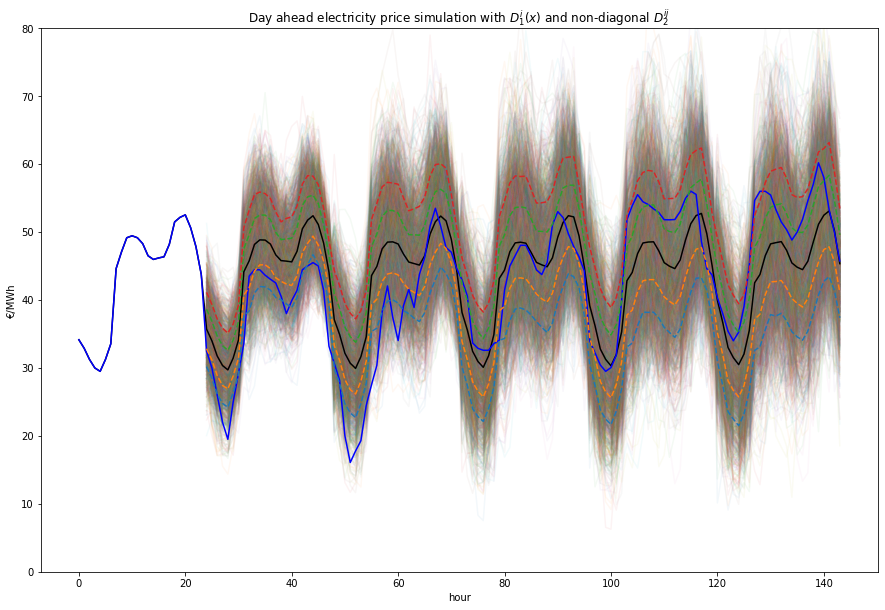

In [80]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_5.num_sim//4].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 80)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^i(x)$ and non-diagonal $D_2^{ij}$")
plt.show()

#### Simulation with $D_{1}^i(x)$ and non-diagonal constant $D_{2}^{ij}$ - higher time resolution

In [81]:
drift_kde = SpatialNearestDriftMultivariate(df=expected_drift_kde_df)
cte_diffusion_kde = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrt_diff_matrix_kde))

em_6 = EulerMaruyama(num_sim=1000, periods=501, delta_t=0.01, nu=0, drift=drift_kde, diffusion=cte_diffusion_kde)

In [82]:
%%time
sim_df = em_6.simulate(x0=x_0, random_seed=124)

CPU times: user 2min 7s, sys: 98.9 ms, total: 2min 8s
Wall time: 2min 8s


In [ ]:
indexes = []
dim = x_0.shape[0]
for i in np.arange((em_6.periods-1)*em_6.delta_t + 1):
    indexes += list(np.arange(int(i*dim*(1/em_6.delta_t)), int(i*dim*(1/em_6.delta_t)+dim)))

In [ ]:
sim_df = sim_df.loc[indexes].reset_index().iloc[:, 1:]

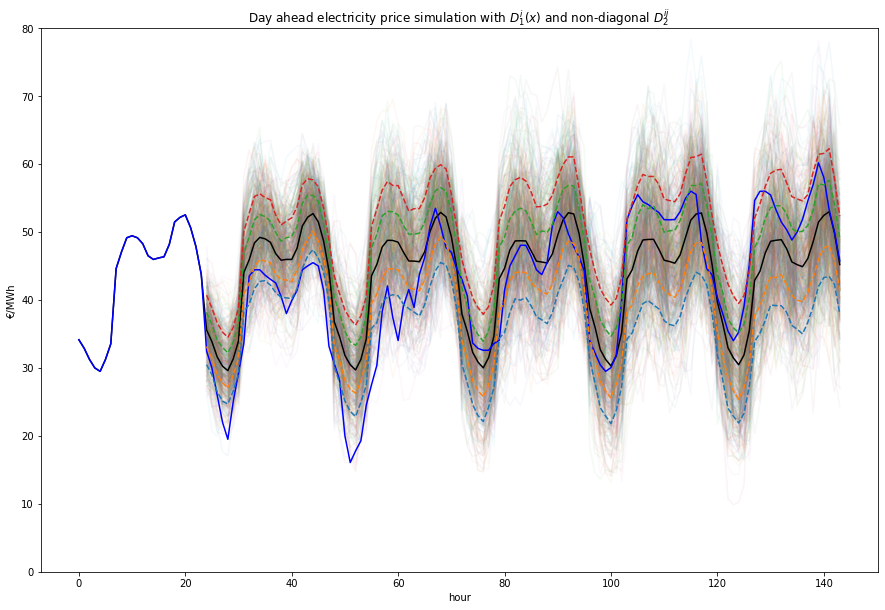

In [66]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_5.num_sim//4].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 80)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^i(x)$ and non-diagonal $D_2^{ij}$")
plt.show()

Compute price inflation as mean daily prices - mean drfit and learn this through a neural ODE